In [2]:
# Importing the libraries
import numpy as np #numerical python
import pandas as pd #panel data
import matplotlib.pyplot as plt #matlab plot library

#Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
print(dataset_train.head())

training_set=dataset_train.iloc[:,1:2].values
print('\n')
training_set


       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800




array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [3]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('\n')
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [4]:
# Creating a data structure with 60 timesteps and 1 output
# Look at the 60 timesteps in the past to get a trend, learn by trial and error
X_train=[]
y_train=[]
# Start from 60th Day and go to 1257 which must be written as 1258
# Memorize the first 60 values to predict the 61st price
# If you use the range function for example range(1,5) then the model stops at 4
for i in range(60,1258):
# example when i=60, [60-60:60,0]
# Implies [0:60,0]
# Data is indexed from 0 so it stops at 59th timestep
  X_train.append(training_set_scaled[i-60:i,0])
  # the value of i=60 in the beginning
  y_train.append(training_set_scaled[i,0])

In [5]:
# X_train and y_train are list and have to be converted to numpy array
# only numpy array can be fed to DNN
# X_train :check the row. It has 60 past values
X_train, y_train = np.array(X_train), np.array(y_train)
print(len(y_train)) #1258-60 = 1198

# Reshaping
# To add dimension to numpy array we must use numpy array
# In Python Shape() is used in panda to give number of row(0)/column(1)
# RNN accepts 3D tensor with shape (batch_size, timesteps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

1198

1198


1198

In [8]:
# Importing the Keras Libraries and Packages
from keras.models import Sequential
from keras.layers import Dense #Hidden layers
from keras.layers import LSTM #Long short term memory
from keras.layers import Dropout #Avoid Overfitting

# Initializing the RNN
# Regressor predicting a stock price so doing regression
# Yt = Alpha*Xt-2 + Gamma*Xt3-3 + Constant
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
# Return_sequences = True because we are going to add another LSTM
# Input_Shape=Input only timesteps and indicator
# The data set X_train.shape[0] will be taken automatically
# The input data is always 3d as required by Keras
# Rate of neurons to drop in a LSTM layer during each iteration of training
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# return_sequences: False so dropped return_sequences as default is false
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

#Adding the output layer and connecting a fully connected layer
regressor.add(Dense(units=1))

#Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
38/38 [==============================] - 14s 139ms/step - loss: 0.0505
Epoch 2/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0061
Epoch 3/100
38/38 [==============================] - 5s 135ms/step - loss: 0.0060
Epoch 4/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0057
Epoch 5/100
38/38 [==============================] - 5s 136ms/step - loss: 0.0051
Epoch 6/100
38/38 [==============================] - 5s 138ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 5s 137ms/step - loss: 0.0047
Epoch 8/100
38/38 [==============================] - 5s 139ms/step - loss: 0.0041
Epoch 9/100
38/38 [==============================] - 5s 142ms/step - loss: 0.0048
Epoch 10/100
38/38 [==============================] - 5s 135ms/step - loss: 0.0042
Epoch 11/100
38/38 [==============================] - 5s 143ms/step - loss: 0.0041
Epoch 12/100
38/38 [==============================] - 5s 138ms/step - loss: 0.0044
Epoch 13/100

In [12]:
# Getting the real stock price of 2017
dataset_test=pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price= dataset_test.iloc[:,1:2].values

# Getting the predicted stock price of 2017
# Some stock price will come from 2016 and some from January 2017
# We will need to concatenate all the stock prices nothing else
# Concat along vertical axis set Axis=0
# Our RNN was trained on scaled input so data set has to be scaled
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']),axis=0)

# First financial day of 2017 - is 3rd January
# We need the first stock price for Jan 2017 upto the last stock price-1 for Jan 2017
# Total length is Train + Test + 20 = 1278
# From 1278-20-60=1198 - This takes you to 6th of October 2016
inputs = dataset_total[len(dataset_total)-len(dataset_test) - 60:].values

# The inputs are not in the form we expected because we have not used the iloc function
# We have provided column as 1 but rows are unknown which is set to -1
# Python on seeing -1 will try to find out the number of rows
# Check what reshape(1,-1) means #count number of columns
inputs=inputs.reshape(-1,1) #Count number of rows
inputs=sc.transform(inputs) # Applying the min-max scaler

# We are only doing prediction so only keep x_test
X_test=[]
# Google Test set has only 20 days, so upperbound is 60+20=80
for i in range(60,80):
  # range in append is taken from the inputs dataset created
  X_test.append(inputs[i-60:i,0])

# Outside the for loop
X_test = np.array(X_test)

# 3D structure is needed as per Keras
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_stock_price = regressor.predict(X_test)
# Get the original scale, so apply min-max inverse
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[760.14636],
       [757.4309 ],
       [757.8596 ],
       [759.2143 ],
       [762.50195],
       [768.3406 ],
       [773.5002 ],
       [775.41187],
       [775.68445],
       [775.4672 ],
       [775.1908 ],
       [774.8074 ],
       [774.4789 ],
       [774.9079 ],
       [775.76666],
       [780.4578 ],
       [787.26263],
       [794.39276],
       [797.94073],
       [793.2717 ]], dtype=float32)

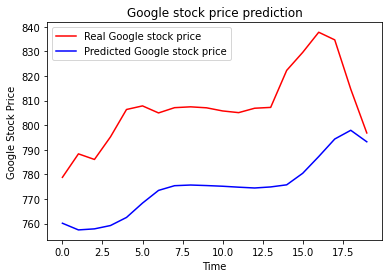

In [13]:
# Visualizing the results
plt.plot(real_stock_price, color='red', label='Real Google stock price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google stock price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()